# О задаче

Решение задачи A чемпионата RuCode осени 2023 направления ИИ моей команды (Мой гитхаб: https://github.com/Lex-TS, сокомандника: https://github.com/Lebedkina)

Для решения задачи регрессии использовался XGBoost, модель предобучилась на данных из второй задачи, задачи B. Они являются частями одной задачи и заголовки данных у них одинаковы. После чего обучается вторая модель на предоставленных организаторами данных для задачи A. В конце результаты прогнозирования записываются в csv файл

По этой задаче мы получили 46.99 баллов из 70 возможных на открытом датасете, а на закрытом тесте 76.51 из 100 в сумме за две задачи A и B. По закрытому датасету для задач A и B заняли 10 место из 15, 1 место по этой задаче в дивизионе Начинающие заняла команда с 81.42 баллами

Наша проблема была в переобученности модели и неправильном понимании сокращений названий признаков, предоставленных в таблице данных. Необходимо было добавить параметры регуляризации для градиентного бустинга, а так же предобработать некоторые признаки. В этом ноутбуке представлено решение, которое мы успели сделать до конца проведения соревнования, оно не улучшено для более точной работы модели, и здесь пока что не исправлены найденные ошибки с переобучением и другие, дающие низкую оценку метрики.

## Комментарий относительно параметров в наборе данных

*После соревнования нами были найдены следующие пояснения к параметрам:*

У. М. — это угол места, откуда пришёл сигнал.

**Азимут** указан для камеры. То есть угол между проекцией линии визирования на горизонт и проекцией нормали камеры на этот горизонт.

**Линия визирования** — это линия, соединяющая центр радиолокатора с центром объекта.

**Доля ВП** — доля сигнала в вертикальной поляризации.

Что означают вертикальные и горизонтальные фазы, а так же модуль сигнала (в чем он измеряется и является ли модуль амплитудой сигнала):

> **Горизонтальные и вертикальные фазы** — это некоторый "дополнительный" признак. Сигнал принимается двумя поляризациями: горизонтальной и вертикальной и обрабатывается раздельно. При цифровой обработке сигнала он разбивается на квадратуры для удобства цифровой обработки.

> **Фаза** — это арктангенс отношения этих квадратур. Данный параметр можно использовать как косвенный признак когерентности приёма от одной выборке к другой, из него ещё можно вытащить много полезного, что может пригодиться.
**Когерентность** - свойство сигнала, у двух выборок можно оценить когерентность.

> **Модуль** измеряется в "кодовых единицах" (безразмерная величина), Модуль является амплитудой сигнала.

#Решение задачи:

##Загрузка данных

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Загрузка данных из гугл диска
# from google.colab import drive
# drive.mount('/content/gdrive/')
# data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dataset_task_/mars-train-regr.csv')
# data_class = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dataset_2/mars-train-class.csv')
# test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dataset/mars-public_test-regr.csv')

In [3]:
#Если запускать ноутбук локально:
data = pd.read_csv('mars-train-regr.csv')
data_class = pd.read_csv('mars-train-class.csv')
test = pd.read_csv('mars-public_test-regr.csv')

##Работа с данными

Изменяются данные из второй задачи для обучения первой модели

In [5]:
data_class_new=data_class.drop('Тип марсианина', axis=1)

In [6]:
data_class_new

,№ испытания,Модуль сигнала,Тип_измерения,Количество импульсов,Фаза Hor,Фаза Ver,Уровень шума,Азимут,У.М.,Секунда,Дальность (м),Доля сигнала в ВП
0,1,908.17,1,1,0.000000,1.570796,83.533212,-26.816982,12.239598,1.869714e+03,3055.921963,0.791666
1,1,1516.59,1,1,1.263076,2.013683,85.718564,27.560049,11.695174,1.869770e+03,2940.934511,0.696507
2,1,5478.08,1,1,0.208487,-1.070217,89.123510,29.888658,11.727221,1.869798e+03,2912.276979,0.987292
3,1,1464.07,1,1,1.708077,0.629192,89.232579,27.540041,11.842715,1.869952e+03,2934.124901,0.619753
4,1,5779.23,1,1,-2.917333,2.235615,92.905241,29.795642,11.873967,1.869980e+03,2906.192231,0.978748
...,...,...,...,...,...,...,...,...,...,...,...,...
11910,3,1021.83,4,1,-0.883251,-1.439784,79.212084,21.014092,21.195597,1.476154e+06,2126.588944,0.962044
11911,3,788.74,4,1,0.595916,0.257432,76.146245,21.013584,21.197932,1.476154e+06,2126.435805,0.972452
11912,3,781.61,4,1,2.384231,2.082473,75.747646,21.013075,21.200262,1.476154e+06,2126.292874,0.953697
11913,3,856.20,4,1,-1.374707,-1.386913,78.541804,21.012567,21.202597,1.476154e+06,2126.139735,0.939917


In [7]:
data

,№ испытания,Модуль сигнала,Тип_измерения,Количество импульсов,Фаза Hor,Фаза Ver,Уровень шума,Азимут,У.М.,Секунда,Дальность (м),Доля сигнала в ВП
0,1,470.071,1,2,0.000000,0.000000,102.693716,-6.514675,12.200567,1.868779e+03,2800.056250,0.910060
1,1,908.170,1,1,0.000000,1.570796,83.533212,-26.816982,12.239598,1.869714e+03,3055.921963,0.791666
2,1,1516.590,1,1,1.263076,2.013683,85.718564,27.560049,11.695174,1.869770e+03,2940.934511,0.696507
3,1,5478.080,1,1,0.208487,-1.070217,89.123510,29.888658,11.727221,1.869798e+03,2912.276979,0.987292
4,1,1464.070,1,1,1.708077,0.629192,89.232579,27.540041,11.842715,1.869952e+03,2934.124901,0.619753
...,...,...,...,...,...,...,...,...,...,...,...,...
20960,3,856.200,4,1,-1.374707,-1.386913,78.541804,21.012567,21.202597,1.476154e+06,2126.139735,0.939917
20961,3,723.650,4,1,-0.698863,-0.401337,70.837544,21.012123,21.204919,1.476154e+06,2125.996804,0.992717
20962,3,900.330,4,1,-1.308619,-1.412748,75.481914,21.011615,21.207249,1.476154e+06,2125.843665,0.933631
20963,3,817.340,4,1,1.259544,1.095978,79.448071,21.011107,21.209584,1.476154e+06,2125.690525,0.928716


###Графики для нахождения и отсеивания ненужных признаков

(12.5, -0.5)

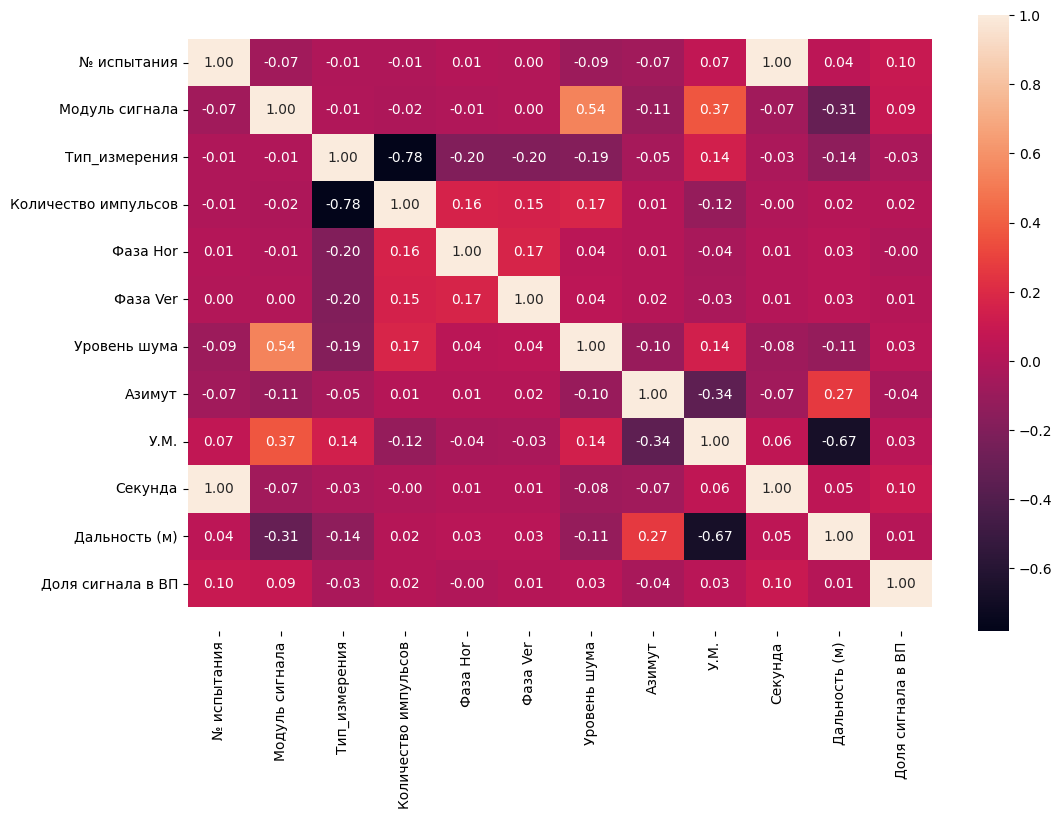

In [8]:
import seaborn as sns
import warnings

plt.figure(figsize = (12,8))
ax = sns.heatmap(data.corr(), annot = True, fmt = ".2f")
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

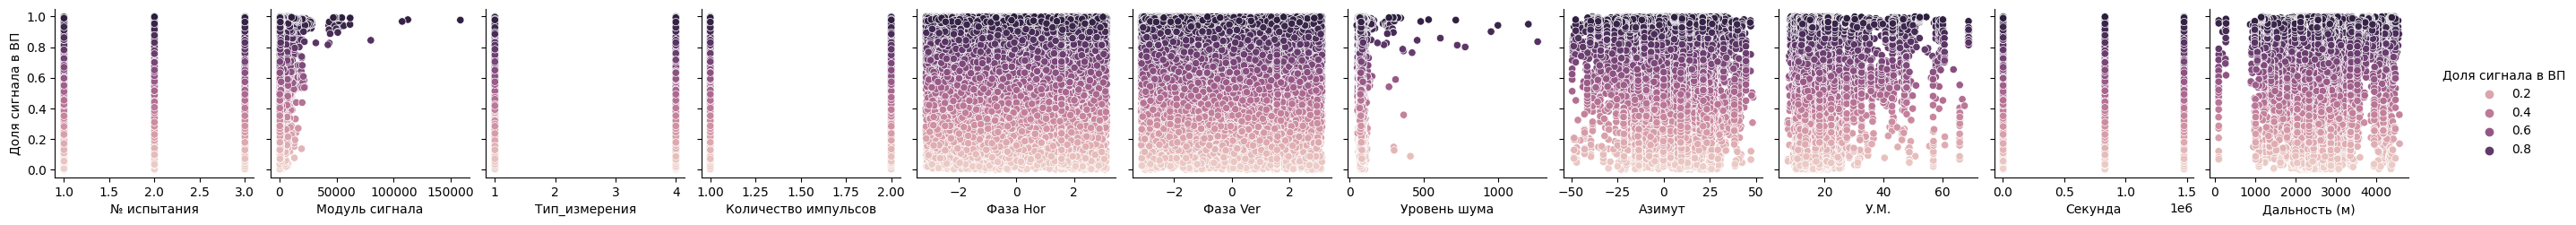

In [9]:
sns.pairplot(data=data, y_vars=["Доля сигнала в ВП"], x_vars=data.columns.drop("Доля сигнала в ВП"), hue='Доля сигнала в ВП')

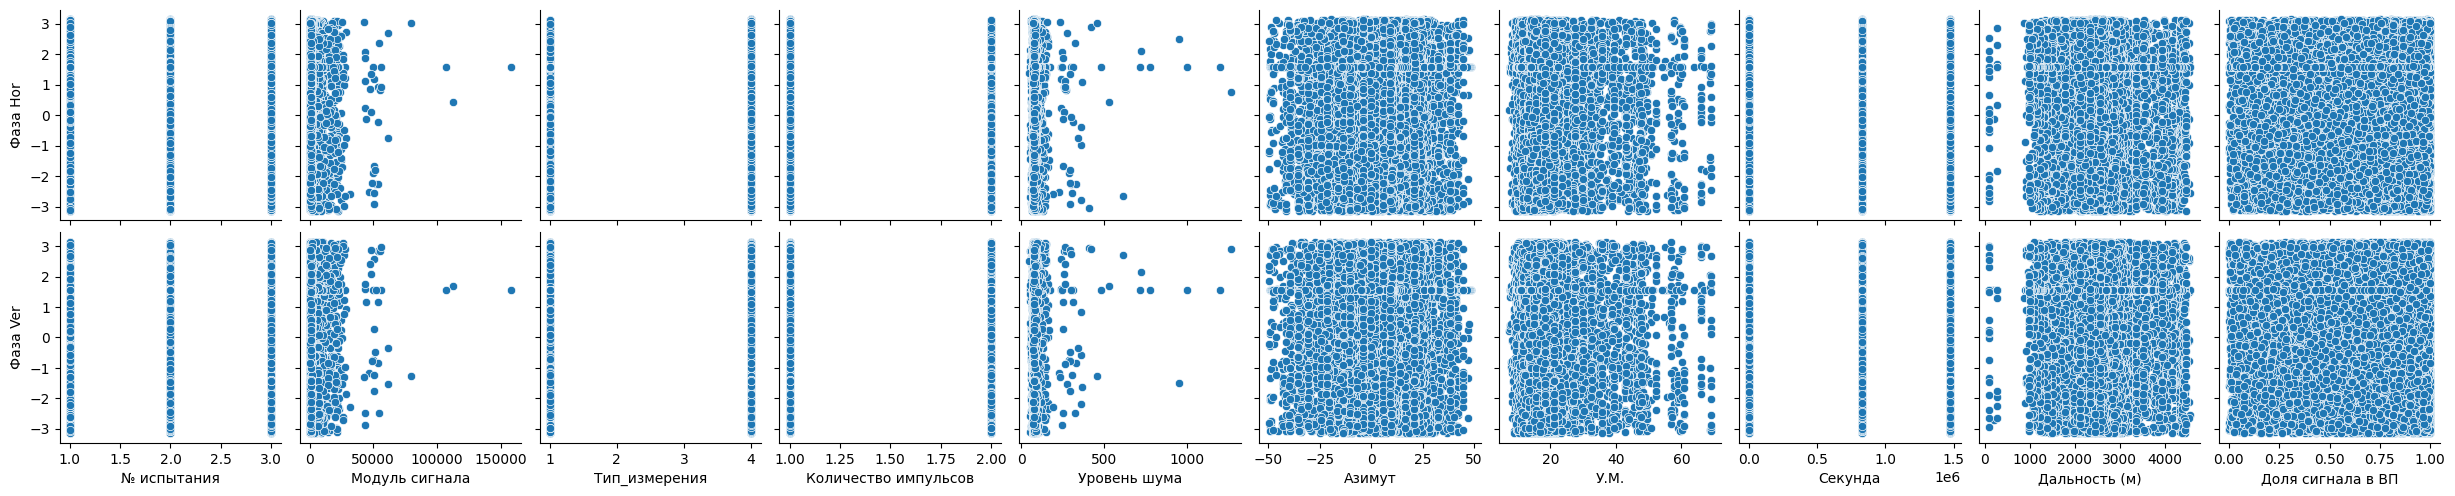

In [10]:
sns.pairplot(data=data, y_vars=["Фаза Hor","Фаза Ver"], x_vars=data.drop(columns=['Фаза Hor', 'Фаза Ver']))

##Обучение первой модели

In [11]:
from sklearn.model_selection import train_test_split

y = data['Доля сигнала в ВП'].copy()

X = data[['Модуль сигнала', 'Азимут', 'У.М.', 'Секунда', 'Дальность (м)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=32)

In [12]:
import xgboost
print(xgboost.__version__)

2.0.0


###Выбор оптимальных параметров для бустинга

In [13]:
from sklearn.model_selection import GridSearchCV

def search(X, y, model, param_name, grid, draw=True):
  parameters = {param_name: grid}

  CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='r2', n_jobs=-1)
  CV_model.fit(X, y)
  means = CV_model.cv_results_['mean_test_score']
  error = CV_model.cv_results_['std_test_score']

  if draw:
    plt.figure(figsize=(15,8))
    plt.title('choose ' + param_name)

    plt.plot(grid, means, label='mean values of score')

    plt.fill_between(grid, means - 2 * error, means + 2 * error, color='green', label='deviation area between errors')
    plt.legend()
    plt.xlabel('parameter')
    plt.ylabel('r2')
    plt.show()

  return means, error

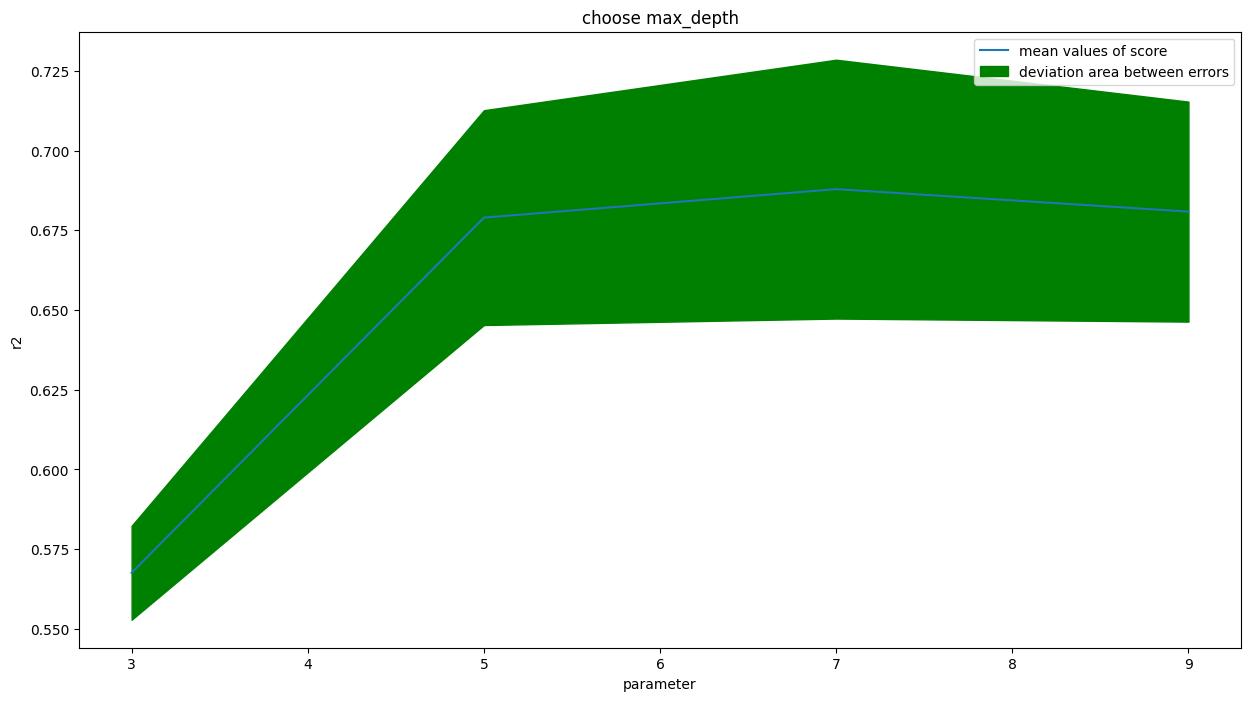

In [14]:
models = [xgboost.XGBRegressor(n_estimators=400)]
param_names = ['max_depth']
grids = [np.arange(3,10,2)]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models, param_names, grids, param_scales):
  search(X_train, y_train, model, param_name, grid, param_scale)

##Обучение

In [17]:
model = xgboost.XGBRegressor(max_depth=7, n_estimators=400, random_state = 32).fit(X_train, y_train)

In [18]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))

0.7023299149942912


##Обучение второй модели на основе первой

In [19]:
y = data_class_new['Доля сигнала в ВП'].copy()

X = data_class_new[['Модуль сигнала', 'Азимут', 'У.М.', 'Секунда', 'Дальность (м)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=23)

In [20]:
model_2 = xgboost.XGBRegressor(max_depth=8, n_estimators=400, random_state = 23).fit(X_train, y_train, xgb_model=model)

In [21]:
y_pred = model_2.predict(X_test)
print(r2_score(y_test, y_pred))

0.7935536002264465


##Использование модели для прогнозирования

In [22]:
# Количество параметров должно совпадать с тем, которое использовалось при обучении
X = test[['Модуль сигнала', 'Азимут', 'У.М.', 'Секунда', 'Дальность (м)']]

y_pred = model.predict(X)
y_pred

array([0.6014315 , 0.6743594 , 0.6321471 , ..., 0.9640108 , 0.9634466 ,
       0.96141577], dtype=float32)

##Запись в csv файл

In [23]:
new_pred = test.copy()
new_pred["Доля сигнала в ВП"] = y_pred
new_pred

,№ испытания,Модуль сигнала,Тип_измерения,Количество импульсов,Фаза Hor,Фаза Ver,Уровень шума,Азимут,У.М.,Секунда,Дальность (м),Доля сигнала в ВП
0,1,2228.58,1,2,-1.296037,-0.823444,95.340461,8.576654,12.988322,1.874687e+03,2789.785685,0.601431
1,1,1886.45,1,2,1.570796,1.570796,96.199134,26.927104,13.798552,1.874785e+03,2734.624786,0.674359
2,1,2015.85,1,2,1.570796,1.570796,87.818645,8.393800,12.966248,1.874883e+03,2785.661124,0.632147
3,1,11495.21,1,2,1.570796,1.570796,71.244075,28.437188,13.875287,1.874953e+03,2706.620650,0.589331
4,1,1595.66,1,2,1.570796,1.570796,82.509944,8.252281,12.861609,1.875092e+03,2781.097562,0.640494
...,...,...,...,...,...,...,...,...,...,...,...,...
4485,3,1127.39,4,1,-2.532464,-2.161597,80.449525,-39.347686,68.876576,1.476153e+06,990.507201,0.964908
4486,3,1015.29,4,1,1.022957,1.786013,85.928771,-39.362483,68.878026,1.476153e+06,990.507201,0.924248
4487,3,1066.67,4,1,-1.177634,-0.582136,80.725173,-39.377443,68.879453,1.476153e+06,990.496991,0.964011
4488,3,1003.16,4,1,2.069521,2.681160,80.661715,-39.392247,68.880902,1.476153e+06,990.486782,0.963447


In [ ]:
#Если хотим сохранять на гугл диск
# new_pred.to_csv('/content/gdrive/My Drive/Colab Notebooks/dataset/task_A.csv',index=False)

In [24]:
new_pred.to_csv('task_A_solution.csv', index=False)

In [ ]:
#Если сохранили на гугл диск
# new_pt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dataset/task_A.csv')
# new_pt

In [26]:
new_pt = pd.read_csv('task_A_solution.csv')
new_pt

,№ испытания,Модуль сигнала,Тип_измерения,Количество импульсов,Фаза Hor,Фаза Ver,Уровень шума,Азимут,У.М.,Секунда,Дальность (м),Доля сигнала в ВП
0,1,2228.58,1,2,-1.296037,-0.823444,95.340461,8.576654,12.988322,1.874687e+03,2789.785685,0.601432
1,1,1886.45,1,2,1.570796,1.570796,96.199134,26.927104,13.798552,1.874785e+03,2734.624786,0.674359
2,1,2015.85,1,2,1.570796,1.570796,87.818645,8.393800,12.966248,1.874883e+03,2785.661124,0.632147
3,1,11495.21,1,2,1.570796,1.570796,71.244075,28.437188,13.875287,1.874953e+03,2706.620650,0.589331
4,1,1595.66,1,2,1.570796,1.570796,82.509944,8.252281,12.861609,1.875092e+03,2781.097562,0.640494
...,...,...,...,...,...,...,...,...,...,...,...,...
4485,3,1127.39,4,1,-2.532464,-2.161597,80.449525,-39.347686,68.876576,1.476153e+06,990.507201,0.964908
4486,3,1015.29,4,1,1.022957,1.786013,85.928771,-39.362483,68.878026,1.476153e+06,990.507201,0.924248
4487,3,1066.67,4,1,-1.177634,-0.582136,80.725173,-39.377443,68.879453,1.476153e+06,990.496991,0.964011
4488,3,1003.16,4,1,2.069521,2.681160,80.661715,-39.392247,68.880902,1.476153e+06,990.486782,0.963447
